In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb
import bisect

from scipy import stats
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

In [2]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv').drop(['X1'], axis=1)
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv').drop(['Id', 'X1'], axis=1)

display(train.head())
display(test.head())

,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,42.9,58.7,14.5,A,4,23,PL233,232,1564


,X2,X3,X4,X5,X6,X7,X8
0,80.6,104.8,11.0,A,29,23,PL234
1,141.8,34.2,17.5,A,2,91,PL911
2,77.2,103.3,17.0,A,10,97,PL973
3,95.5,131.0,18.0,A,2,23,PL234
4,91.7,36.1,19.0,AH32,1,27,PL271


| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X2      121754 non-null  float64
 1   X3      121754 non-null  float64
 2   X4      121754 non-null  float64
 3   X5      121754 non-null  object 
 4   X6      121754 non-null  int64  
 5   X7      121754 non-null  int64  
 6   X8      121754 non-null  object 
 7   Y1      121754 non-null  int64  
 8   Y2      121754 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 8.4+ MB


In [4]:
train.describe()

,X2,X3,X4,X6,X7,Y1,Y2
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,77.608615,73.875636,17.444897,13.630049,43.921152,8.971671e+02,2193.206638
std,48.006125,53.267359,4.498316,20.751914,32.509414,4.604704e+04,2299.585390
min,3.200000,1.800000,6.000000,1.000000,14.000000,0.000000e+00,0.000000
25%,45.200000,40.900000,14.500000,1.000000,22.000000,2.380000e+02,1064.000000
50%,68.100000,52.800000,17.000000,4.000000,25.000000,3.790000e+02,1593.000000
75%,98.300000,93.000000,20.000000,18.000000,91.000000,5.480000e+02,2778.000000
max,524.400000,621.300000,40.000000,416.000000,97.000000,6.157364e+06,348262.000000


# 특징 만들기


In [5]:
train['X8'] = train['X8'].str.extract(r'(PL|PS)')
test['X8'] = test['X8'].str.extract(r'(PL|PS)')

In [6]:
train['X8_encoded'] = (train['X8'] != 'PL').astype(int)
test['X8_encoded'] = (test['X8'] != 'PL').astype(int)

train = pd.get_dummies(train, columns=['X8_encoded'], prefix=['X8'])
test = pd.get_dummies(test, columns=['X8_encoded'], prefix=['X8'])

train[['X8_0', 'X8_1']] = train[['X8_0', 'X8_1']].astype(int)
test[['X8_0', 'X8_1']] = test[['X8_0', 'X8_1']].astype(int)

In [7]:
import re

def convert_x5(value):
    # -TM 이 포함되어 있으면 제거하고 숫자로 변환, 그렇지 않으면 그냥 숫자로 변환
    if '-TM' in value:
        value = value.replace('-TM', '')
    match = re.search(r'\d+', value)  # 정규표현식을 사용하여 숫자 추출
    if match:
        return int(match.group()) * 9.8
    else:
        return 235  # 숫자가 없는 경우 235로 설정

# X5 열에 변환 함수 적용
train['X5_numeric'] = train['X5'].apply(convert_x5)
test['X5_numeric'] = test['X5'].apply(convert_x5)

<Axes: xlabel='X2', ylabel='X3'>

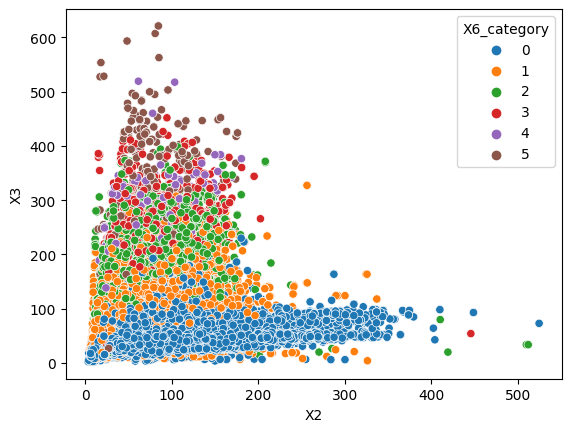

In [8]:
bins = [0, 15, 40, 70, 95, 110, float('inf')]

labels = [0, 1, 2, 3, 4, 5]

train['X6_category'] = pd.cut(train['X6'], bins = bins, labels = labels, include_lowest = True)
test['X6_category'] = pd.cut(test['X6'], bins = bins, labels = labels, include_lowest = True)

train.drop(columns = ['X6'], inplace = True)
test.drop(columns = ['X6'], inplace = True)

sns.scatterplot(x=train['X2'], y=train['X3'], hue = train['X6_category'].astype('category'))

In [9]:
train['X4'].unique()

array([22.5, 13. , 18. , 15. , 14.5, 14. , 21. , 19.5, 19. , 20.5, 16. ,
       20. , 25. , 13.5, 11. , 12. , 28. , 30. , 15.5, 17. , 10. , 22. ,
       21.5, 23. , 15.1, 34. , 27. , 18.5, 26. , 26.5, 12.5, 17.5, 24. ,
       36. , 25.5, 23.5, 16.5,  9. ,  6. , 24.5, 32. ,  8.1, 35. , 10.5,
       11.5,  7.1, 31. ,  7. ,  8. ,  9.5, 35.5, 28.5, 34.5, 27.5, 33. ,
       29.5, 29. , 30.5, 20.1, 32.5, 33.5, 31.5, 40. ])

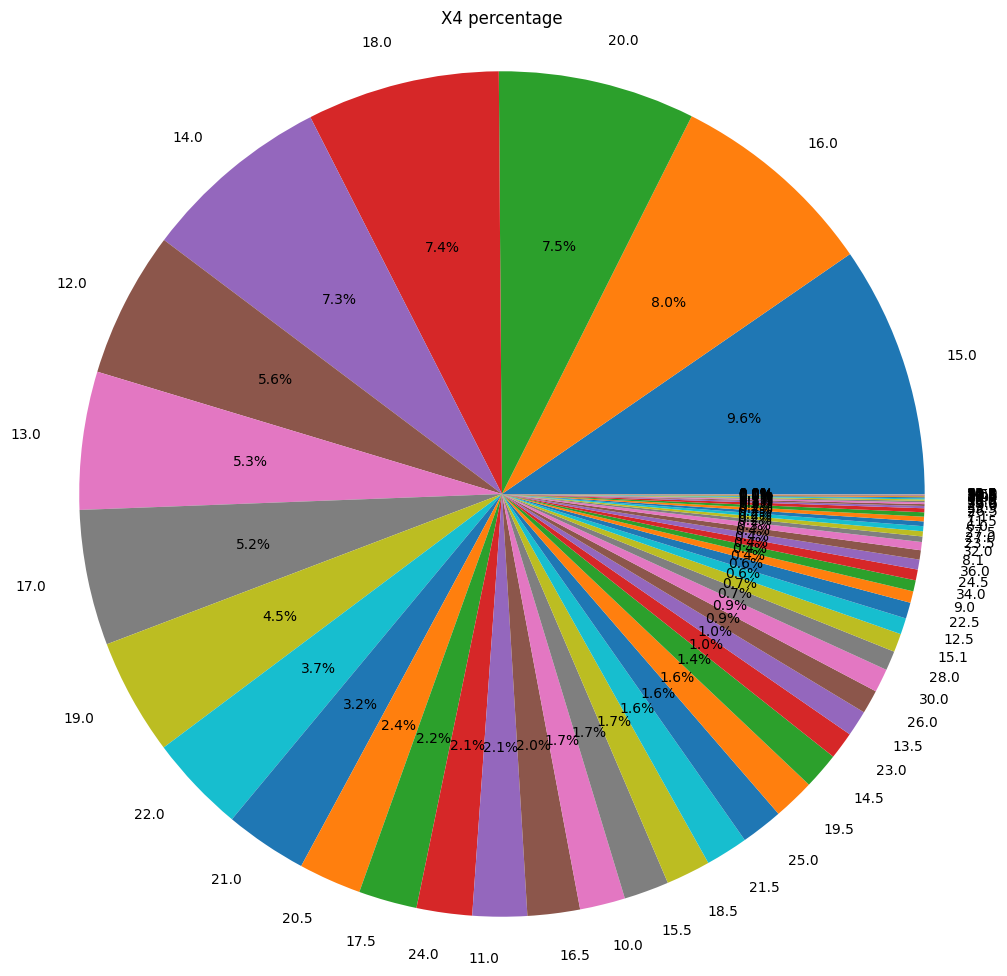

In [10]:
x4_counts = train['X4'].value_counts()

plt.figure(figsize = (12, 12))
plt.pie(x4_counts, labels=x4_counts.index, autopct='%1.1f%%')

plt.axis('equal')  # 원형으로 나오도록 설정
plt.title('X4 percentage')  # 차트 제목 (선택사항)
plt.show()  # 차트 보이기

In [11]:
# bins = [0, 10, 12, 20, 25, 30, float('inf')]

# labels = [0, 1, 2, 3, 4, 5]

# train['X4_category'] = pd.cut(train['X4'], bins = bins, labels = labels, include_lowest = True)
# test['X4_category'] = pd.cut(test['X4'], bins = bins, labels = labels, include_lowest = True)

# train.drop(columns = ['X4'], inplace = True)
# test.drop(columns = ['X4'], inplace = True)

In [12]:
categorical_features = ['X5', 'X8']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 2/2 [00:00<00:00, 21.88it/s]


In [13]:
scaler = StandardScaler()

columns_to_scale = ['X2', 'X3', 'X4']

train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

In [14]:
train['Y1_log'] = np.log1p(train['Y1'])
train['Y2_log'] = np.log1p(train['Y2'])

train

,X2,X3,X4,X5,X7,X8,Y1,Y2,X8_0,X8_1,X5_numeric,X6_category,Y1_log,Y2_log
0,-0.443875,-0.119692,1.123781,10,97,0,467,2241,1,0,313.6,0,6.148468,7.715124
1,0.778891,-0.129078,-0.988129,10,27,0,1058,1163,1,0,313.6,0,6.965080,7.059618
2,-0.383465,-0.549600,0.123403,11,14,0,270,1094,1,0,313.6,0,5.602119,6.998510
3,-0.531364,0.441630,-0.543516,3,24,0,391,2604,1,0,235.0,1,5.971262,7.865188
4,-0.723007,-0.284897,-0.654669,3,23,0,232,1564,1,0,235.0,0,5.451038,7.355641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121749,0.433100,0.293321,-1.655048,8,21,1,906,1226,0,1,235.0,0,6.810142,7.112327
121750,-0.616770,-0.429451,1.234935,54,23,0,175,1540,1,0,352.8,0,5.170484,7.340187
121751,-0.731339,-0.819936,3.680304,40,27,0,376,1492,1,0,352.8,0,5.932245,7.308543
121752,-1.156287,-1.099658,4.124917,15,97,0,85,723,1,0,352.8,0,4.454347,6.584791


In [15]:
columns_to_check = ['Y1_log', 'Y2_log']

for column in columns_to_check:
    mean = train[column].mean()
    std_dev = train[column].std()

    # 3시그마 범위 계산
    upper_limit = mean + 3 * std_dev
    lower_limit = mean - 3 * std_dev

    # 3시그마 범위 내의 데이터 포인트 유지
    train = train[(train[column] >= lower_limit) & (train[column] <= upper_limit)]

filtered_train = train

In [16]:
# columns_to_dbscan = ['X2', 'X3', 'X5', 'X7', 'X8', 'X8_0', 'X8_1']

# dbscan = DBSCAN(eps=0.5, min_samples=5)
# train['cluster'] = dbscan.fit_predict(train[columns_to_dbscan])

# # 클러스터가 -1인 것은 이상치로 간주하고 제거
# filtered_train = train[train['cluster'] != -1].drop(columns=['cluster'])

# filtered_train

In [17]:
filtered_train.drop(columns = ['Y1_log', 'Y2_log'], inplace = True)
filtered_train

,X2,X3,X4,X5,X7,X8,Y1,Y2,X8_0,X8_1,X5_numeric,X6_category
0,-0.443875,-0.119692,1.123781,10,97,0,467,2241,1,0,313.6,0
1,0.778891,-0.129078,-0.988129,10,27,0,1058,1163,1,0,313.6,0
2,-0.383465,-0.549600,0.123403,11,14,0,270,1094,1,0,313.6,0
3,-0.531364,0.441630,-0.543516,3,24,0,391,2604,1,0,235.0,1
4,-0.723007,-0.284897,-0.654669,3,23,0,232,1564,1,0,235.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
121749,0.433100,0.293321,-1.655048,8,21,1,906,1226,0,1,235.0,0
121750,-0.616770,-0.429451,1.234935,54,23,0,175,1540,1,0,352.8,0
121751,-0.731339,-0.819936,3.680304,40,27,0,376,1492,1,0,352.8,0
121752,-1.156287,-1.099658,4.124917,15,97,0,85,723,1,0,352.8,0


In [18]:
# exclude_columns = ['cluster']

# num_columns = len(filtered_train.columns) - len(exclude_columns)
# num_rows = (num_columns - 1) // 4 + 1 

# fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, num_rows * 4))
# axes = axes.flatten()

# index = 0
# for i, column in enumerate(filtered_train.columns):
#     if column not in exclude_columns:
#         sns.histplot(data=filtered_train, x=column, kde=True, ax=axes[index])
#         axes[index].set_title(f'Histogram of {column}')
#         axes[index].set_xlabel('Values')
#         axes[index].set_ylabel('Frequency')
#         index += 1

# for i in range(index, len(axes)):
#     fig.delaxes(axes[i])

# plt.tight_layout()  
# plt.show()

In [19]:
xgb_y1 = xgb.XGBRegressor(eval_metric='mae',
                          enable_categorical=True 
                          )

X_train_reduced = filtered_train.drop(columns = ['Y1', 'Y2']).reset_index(drop=True)
y_train = filtered_train['Y1'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    xgb_y1.fit(X_t, y_t, eval_set=[(X_val, y_val)], verbose=50)

    val_pred = xgb_y1.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    test = test[X_train_reduced.columns]

    xgb_pred = xgb_y1.predict(test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

final_predictions_y1 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-mae:169.93212


[50]	validation_0-mae:104.68671
[99]	validation_0-mae:105.04794


Processing folds:  20%|██        | 1/5 [00:00<00:02,  1.76it/s]

[0]	validation_0-mae:168.16530
[50]	validation_0-mae:102.10619
[99]	validation_0-mae:102.55505


Processing folds:  40%|████      | 2/5 [00:00<00:01,  2.10it/s]

[0]	validation_0-mae:167.54299
[50]	validation_0-mae:102.35140
[99]	validation_0-mae:103.29672


Processing folds:  60%|██████    | 3/5 [00:01<00:00,  2.19it/s]

[0]	validation_0-mae:166.95110
[50]	validation_0-mae:102.86985
[99]	validation_0-mae:103.67566


Processing folds:  80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

[0]	validation_0-mae:169.41398
[50]	validation_0-mae:102.83279
[99]	validation_0-mae:103.15111


Processing folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

Validation : MAE scores for each fold: [105.04793710197735, 102.5550515373399, 103.29672465359758, 103.67565700213588, 103.15111256331556]
Validation : MAE: 103.54529657167328


In [20]:
xgb_y2 = xgb.XGBRegressor(eval_metric='mae',
                          enable_categorical=True 
                          )

X_train_reduced = filtered_train.drop(columns = ['Y1', 'Y2']).reset_index(drop=True)
y_train = filtered_train['Y2'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    xgb_y2.fit(X_t, y_t, eval_set=[(X_val, y_val)], verbose=50)

    val_pred = xgb_y2.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    xgb_pred = xgb_y2.predict(test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

final_predictions_y2 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-mae:901.68738
[50]	validation_0-mae:265.19527
[99]	validation_0-mae:266.30587


Processing folds:  20%|██        | 1/5 [00:00<00:02,  1.83it/s]

[0]	validation_0-mae:895.56812
[50]	validation_0-mae:251.92124
[99]	validation_0-mae:252.45344


Processing folds:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

[0]	validation_0-mae:894.85830
[50]	validation_0-mae:255.90731
[99]	validation_0-mae:256.97231


Processing folds:  60%|██████    | 3/5 [00:01<00:01,  1.87it/s]

[0]	validation_0-mae:886.87626
[50]	validation_0-mae:254.84454
[99]	validation_0-mae:256.61986


Processing folds:  80%|████████  | 4/5 [00:02<00:00,  1.99it/s]

[0]	validation_0-mae:897.06059
[50]	validation_0-mae:257.67223
[99]	validation_0-mae:258.86364


Processing folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

Validation : MAE scores for each fold: [266.3058724421642, 252.45343640791975, 256.97230498635827, 256.6198566589836, 258.863640039638]
Validation : MAE: 258.2430221070128


In [21]:
submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\sample_submission.csv')

submit.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [22]:
final_predictions = final_predictions_y1 + final_predictions_y2


submit.iloc[:, 1] = final_predictions

submit

,Id,Predicted
0,0,2962.037109
1,1,1745.371582
2,2,3238.787598
3,3,4165.574707
4,4,1347.344727
...,...,...
40566,40566,960.443481
40567,40567,1211.005005
40568,40568,2021.392944
40569,40569,1434.177124


In [23]:
submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_CNC\\1120-10.csv', index=False)